In [1]:
from tensorflow.keras.applications import ResNet50

2022-12-13 09:54:56.621106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ref_dir = './FID-300/references/'
dataset_dir = './FID-300/tracks_cropped/'


In [3]:
import PIL
import pathlib
import tensorflow as tf

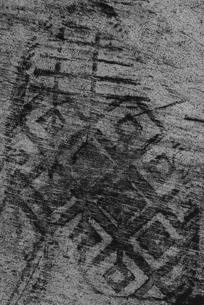

In [4]:
PIL.Image.open('./FID-300/tracks_cropped/00001.jpg')

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as k
import numpy as np
# Import RESNET50 without top (we need to extract features)
model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


2022-12-13 09:54:58.230614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 09:54:58.240792: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
inputs = Input((224,224,3))
baseModel = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
for layer in baseModel.layers:
        layer.trainable = False

In [7]:
def create_model():
    inputs = Input((224,224,3))
    x = baseModel(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    model = Model(inputs, x)
    return model


In [8]:
# head = tf.keras.layers.Flatten()(model.output)
# head = tf.keras.layers.Dense(128, activation='relu')(head)

# # head = tf.keras.layers.MaxPooling2D(pool_size=2)(model.output)

# sister = tf.keras.models.Model(inputs=model.input, outputs=head)
# sister2 = tf.keras.models.Model(inputs=model.input, outputs=head)

In [9]:
feature_extractor = create_model()
imgA = Input(shape=(224,224,3))
imgB = Input(shape=(224,224,3))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

In [10]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          36432896    ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

In [ ]:
#https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4
#generate training pairs